# Examining Environmental Justice through Open Source, Cloud-Native Tools

This Jupyter notebook provides a brief introduction to a cloud-native workflow.  

_Note: in Codespaces editor, choose "Select Kernel" -> "Jupyter Kernels" -> "R" to get started._

In [ ]:
library(rstac)
library(gdalcubes)
library(stars)
library(tmap)
gdalcubes::gdalcubes_options(parallel = TRUE)

In [2]:
box <- c(xmin=-122.51006, ymin=37.70801, xmax=-122.36268, ymax=37.80668) 
start_date <- "2022-06-01"
end_date <- "2022-08-01"
items <-
  stac("https://earth-search.aws.element84.com/v0/") |>
  stac_search(collections = "sentinel-s2-l2a-cogs",
              bbox = box,
              datetime = paste(start_date, end_date, sep="/"),
              limit = 100) |>
  post_request()


In [ ]:

col <- stac_image_collection(items$features,
                             asset_names = c("B04", "B08", "SCL"),
                             property_filter = \(x){
                               x[["eo:cloud_cover"]] < 20
                             })

cube <- cube_view(srs = "EPSG:4326",
                  extent = list(t0 = start_date, t1 = end_date,
                                left = box[1], right = box[3],
                                top = box[4], bottom = box[2]),
                  nx = 1200, ny = 1200, dt = "P1D",
                  aggregation = "median", resampling = "average")

mask <- image_mask("SCL", values=c(3, 8, 9)) # mask clouds and cloud shadows


In [5]:

ndvi <- raster_cube(col, cube, mask = mask) |>
  select_bands(c("B04", "B08")) |>
  apply_pixel("(B08-B04)/(B08+B04)", "NDVI") |>
  reduce_time(c("mean(NDVI)"))

ndvi_stars <- st_as_stars(ndvi)

We can also extract values at particular points or values falling within particular polygons.  One common operation is to summarise the values of all pixels falling within a given polygon, e.g. by the average value. 

Here, we examine the present-day impact of historic "red-lining" of US cities during the Great Depression using data from the [Mapping Inequality](https://dsl.richmond.edu/panorama/redlining) project.  All though this racist practice was banned by federal law under the Fair Housing Act of 1968, the systemic scars of that practice are still so deeply etched on our landscape that the remain visible from space -- "red-lined" areas (graded "D" under the racist HOLC scheme) show systematically lower greenness than predominately-white neighborhoods (Grade "A"):

In [6]:
sf <- st_read("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/downloads/geojson/CASanFrancisco1937.geojson") |>
  st_make_valid()
poly <- ndvi |> extract_geom(sf, FUN = mean, reduce_time = TRUE)
sf$NDVI <- poly$NDVI

Reading layer `CASanFrancisco1937' from data source 
  `/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/downloads/geojson/CASanFrancisco1937.geojson' 
  using driver `GeoJSON'
Simple feature collection with 97 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -122.5101 ymin: 37.70801 xmax: -122.3627 ymax: 37.80668
Geodetic CRS:  WGS 84


Warning message:
“v3 code detected: as of tmap v4, tm_legend should be specified per visual variable (e.g. with the argument fill.legend of tm_polygons”
Warning message in value[[3L]](cond):
“could not rename the data.table”


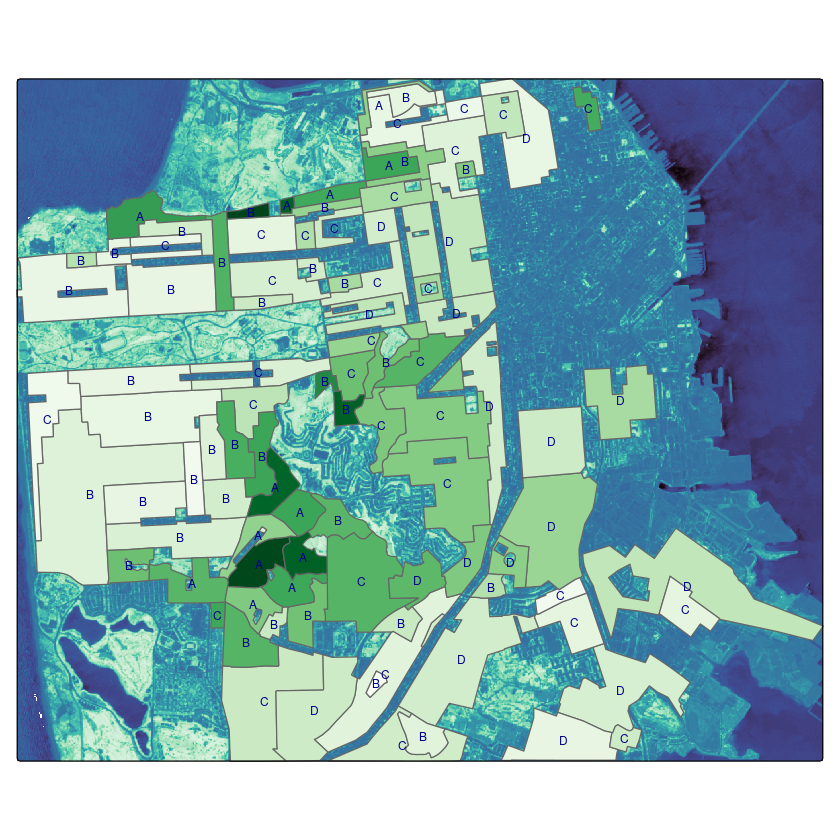

In [7]:
mako <- tm_scale_continuous(values = viridisLite::mako(30))
fill <- tm_scale_continuous(values = "Greens")

tm_shape(ndvi_stars) + tm_raster(col.scale = mako) +
  tm_shape(sf) + tm_polygons('NDVI', fill.scale = fill) +
  tm_shape(sf) + tm_text("holc_grade", col="darkblue", size=0.6) +
  tm_legend_hide()

We plot the underlying NDVI as well as the average NDVI of each polygon, along with it's textual grade, using `tmap`.  Note that "A" grades tend to be darkest green (high NDVI) while "D" grades are frequently the least green.  (Regions not zoned for housing at the time of the 1937 housing assessment are not displayed as polygons.)